# SLT 5A Fruits Classification HW4
Barot, Del Carmen, Jimenez

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import time

# Exploratory Data Analysis

## Data Loading

The fruit classification dataset consists of 7 features with 59 observations. The target variable here is `fruit_name` which falls within 4 classes: `apple`, `mandarin`, `orange` and `lemon`. `fruit_label` is simply the label-encoded version of `fruit_name`.

In [4]:
fruits = pd.read_table('fruit_data_with_colors.txt')
fruits.head()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.60
3,2,mandarin,mandarin,86,6.2,4.7,0.80
4,2,mandarin,mandarin,84,6.0,4.6,0.79


In [5]:
print(fruits.shape)

(59, 7)


In [6]:
fruit_names = fruits['fruit_name'].unique()
colors = ['red', 'green', 'xkcd:tangerine', 'xkcd:dull yellow']
numeric_cols = ['mass', 'width', 'height', 'color_score']

## Histograms

Histograms were made to visualize the distribution of numerical features. Because a label-encoded target feature like `fruit_label` is not truly numerical or ordinal in nature, this was omitted from the histograms.

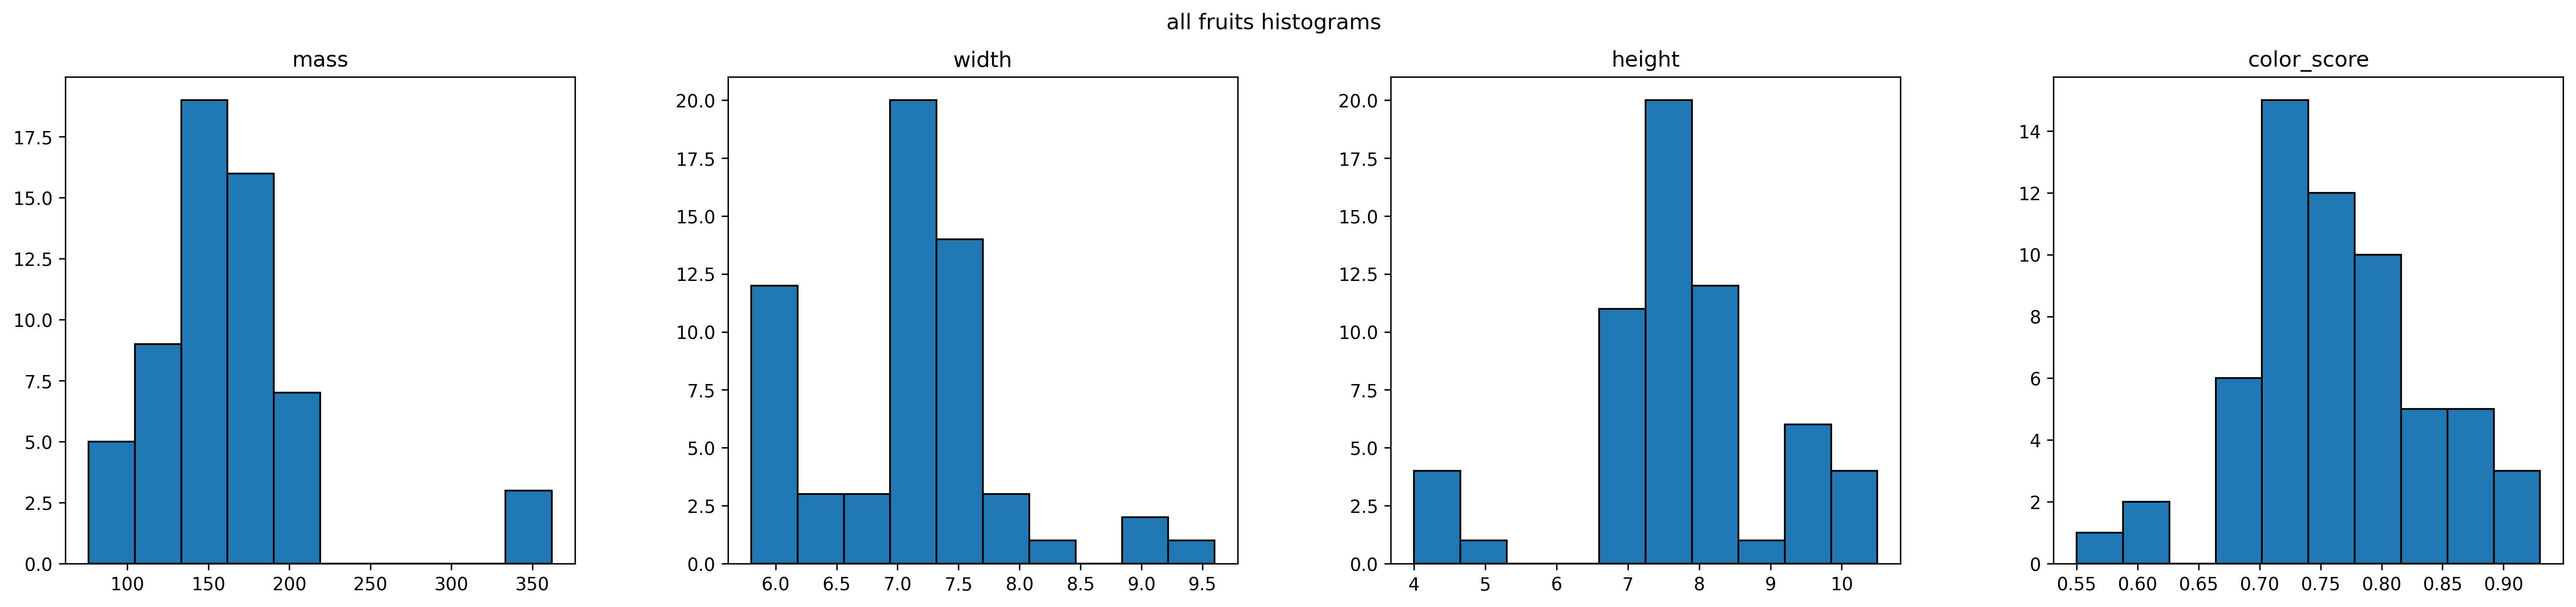

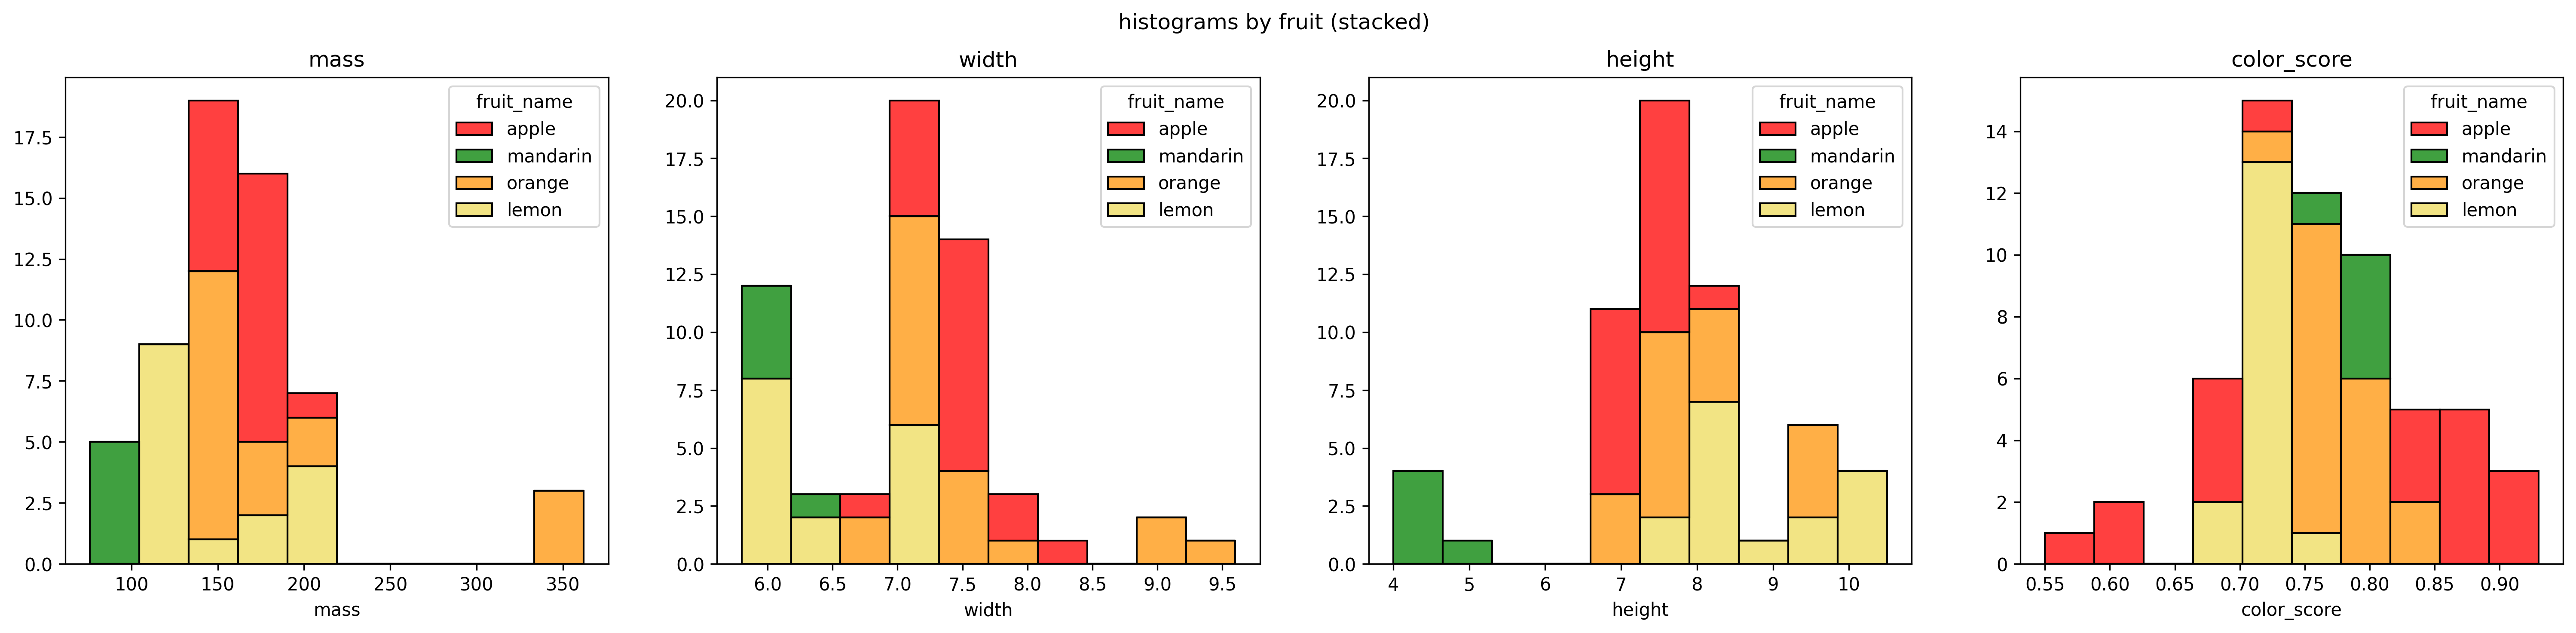

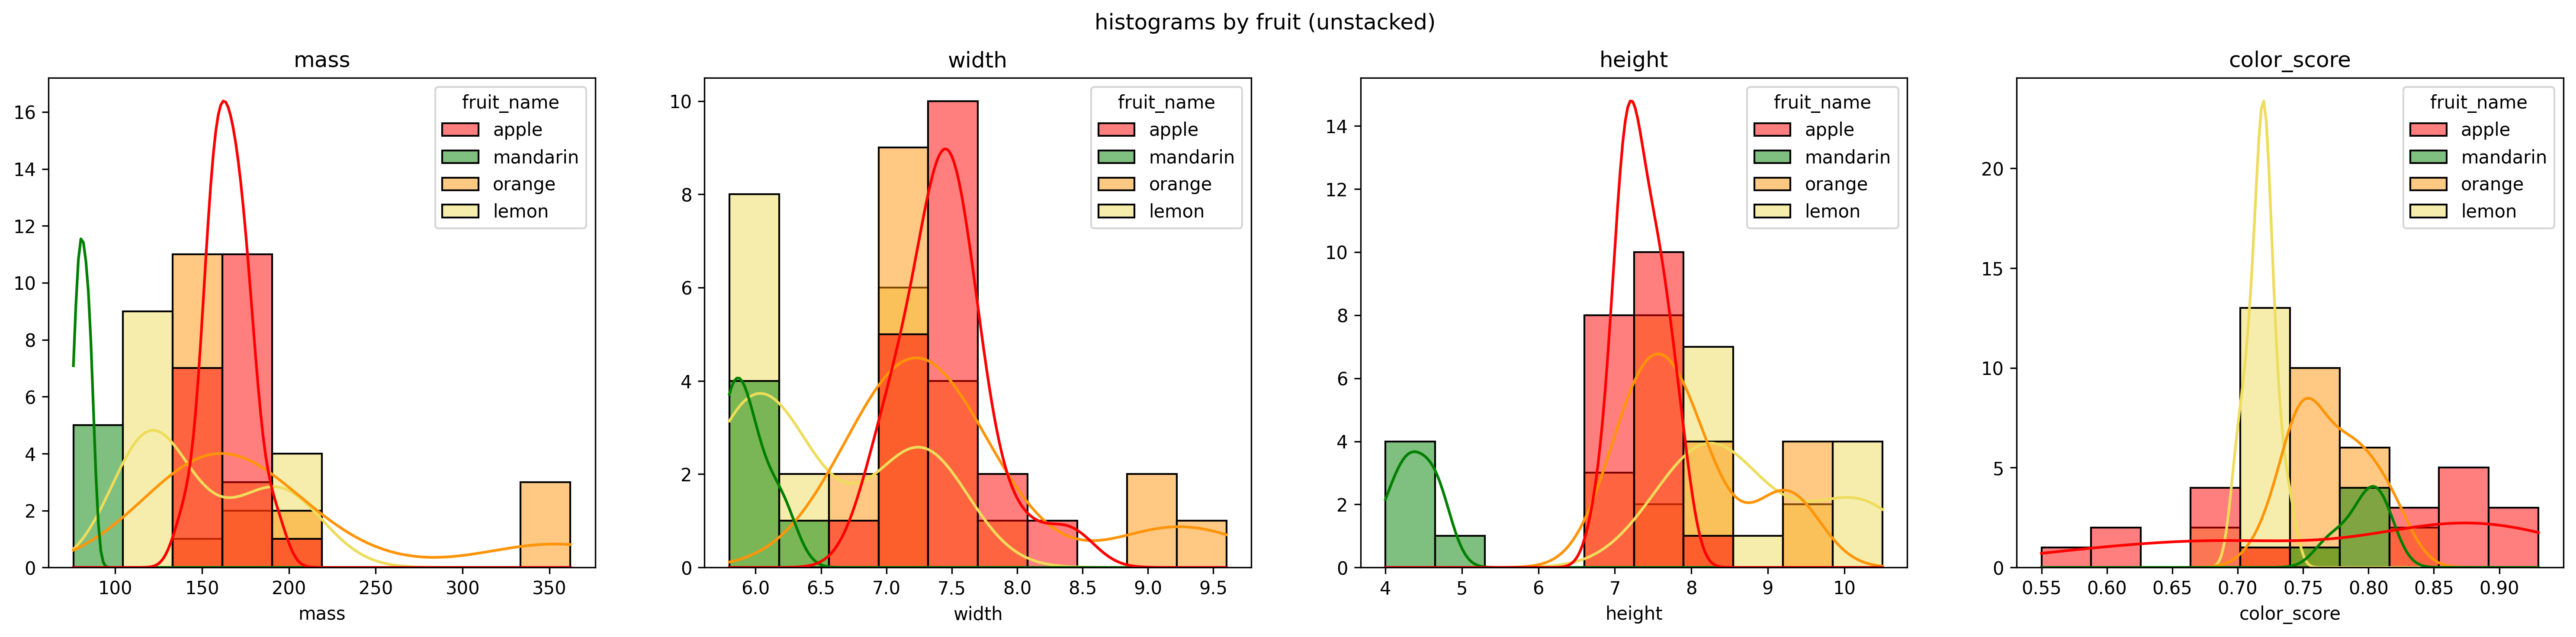

In [ ]:
# Plot all fruit histograms
fig, ax = plt.subplots(1, 4, figsize=(25, 5))
fruits[numeric_cols].hist(ax=ax, grid=False, edgecolor='black')
plt.suptitle('all fruits histograms')
plt.show()

# Plot all fruit histograms, color coded by fruit (stacked)
fig, ax = plt.subplots(1, 4, figsize=(25, 5))
for a, feature in enumerate(numeric_cols):
    sns.histplot(data=fruits, x=feature, hue='fruit_name', palette=colors, ax=ax[a], multiple='stack', bins=10)
    ax[a].set_ylabel('')
    ax[a].set_title(ax[a].get_xlabel())
plt.suptitle('histograms by fruit (stacked)')
plt.show()

# Plot all fruit histograms, color coded by fruit (unstacked)
fig, ax = plt.subplots(1, 4, figsize=(25, 5))
for a, feature in enumerate(numeric_cols):
    sns.histplot(data=fruits, x=feature, hue='fruit_name', palette=colors, ax=ax[a], kde=True, bins=10)
    ax[a].set_ylabel('')
    ax[a].set_title(ax[a].get_xlabel())
plt.suptitle('histograms by fruit (unstacked)')
plt.show()

Separate histograms were made also per fruit class. Due to the lack of datapoints, especially for classes like `mandarin`, which only has 5 observations, not much can be gleaned from the shape.

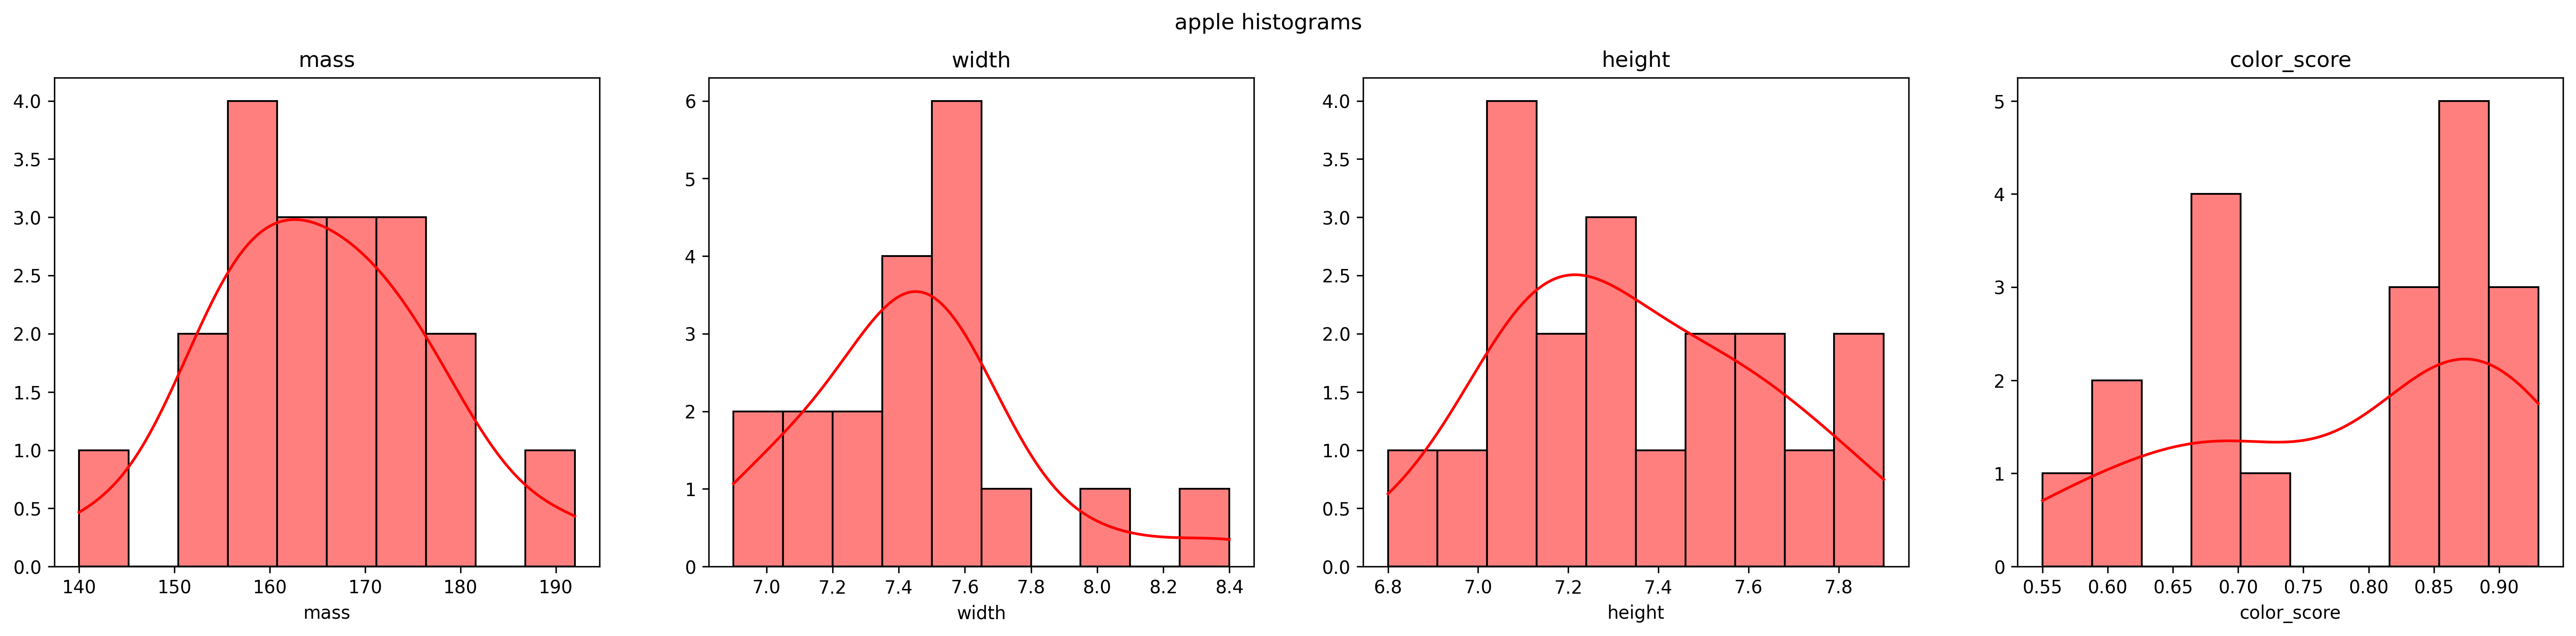

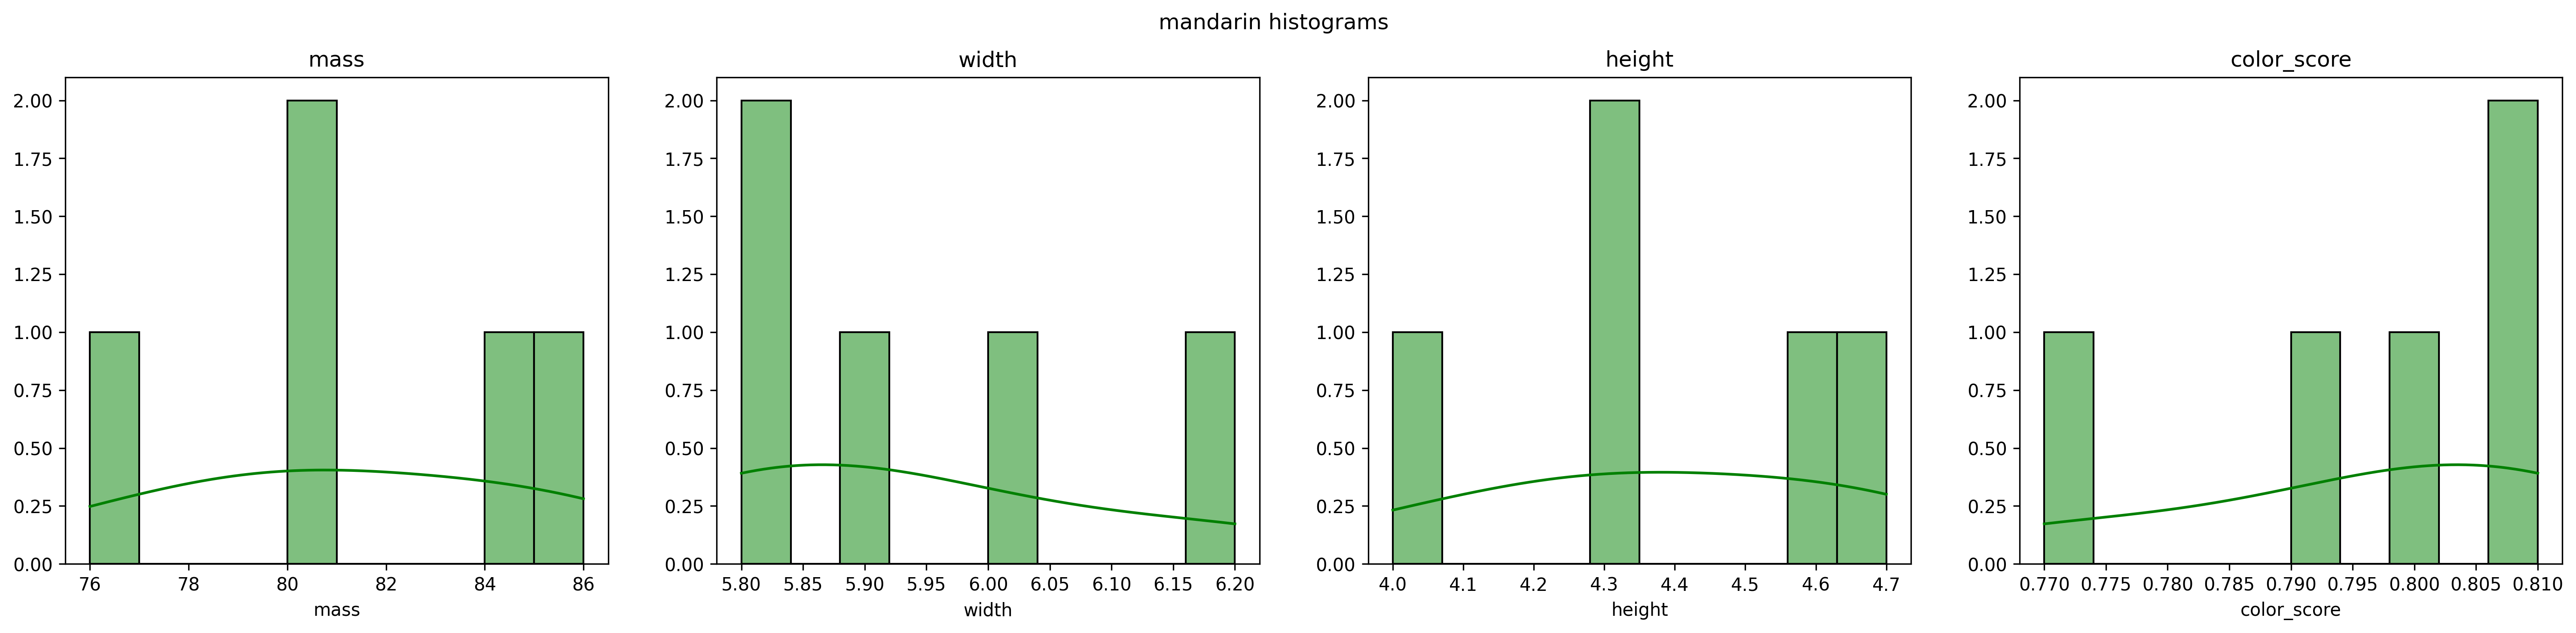

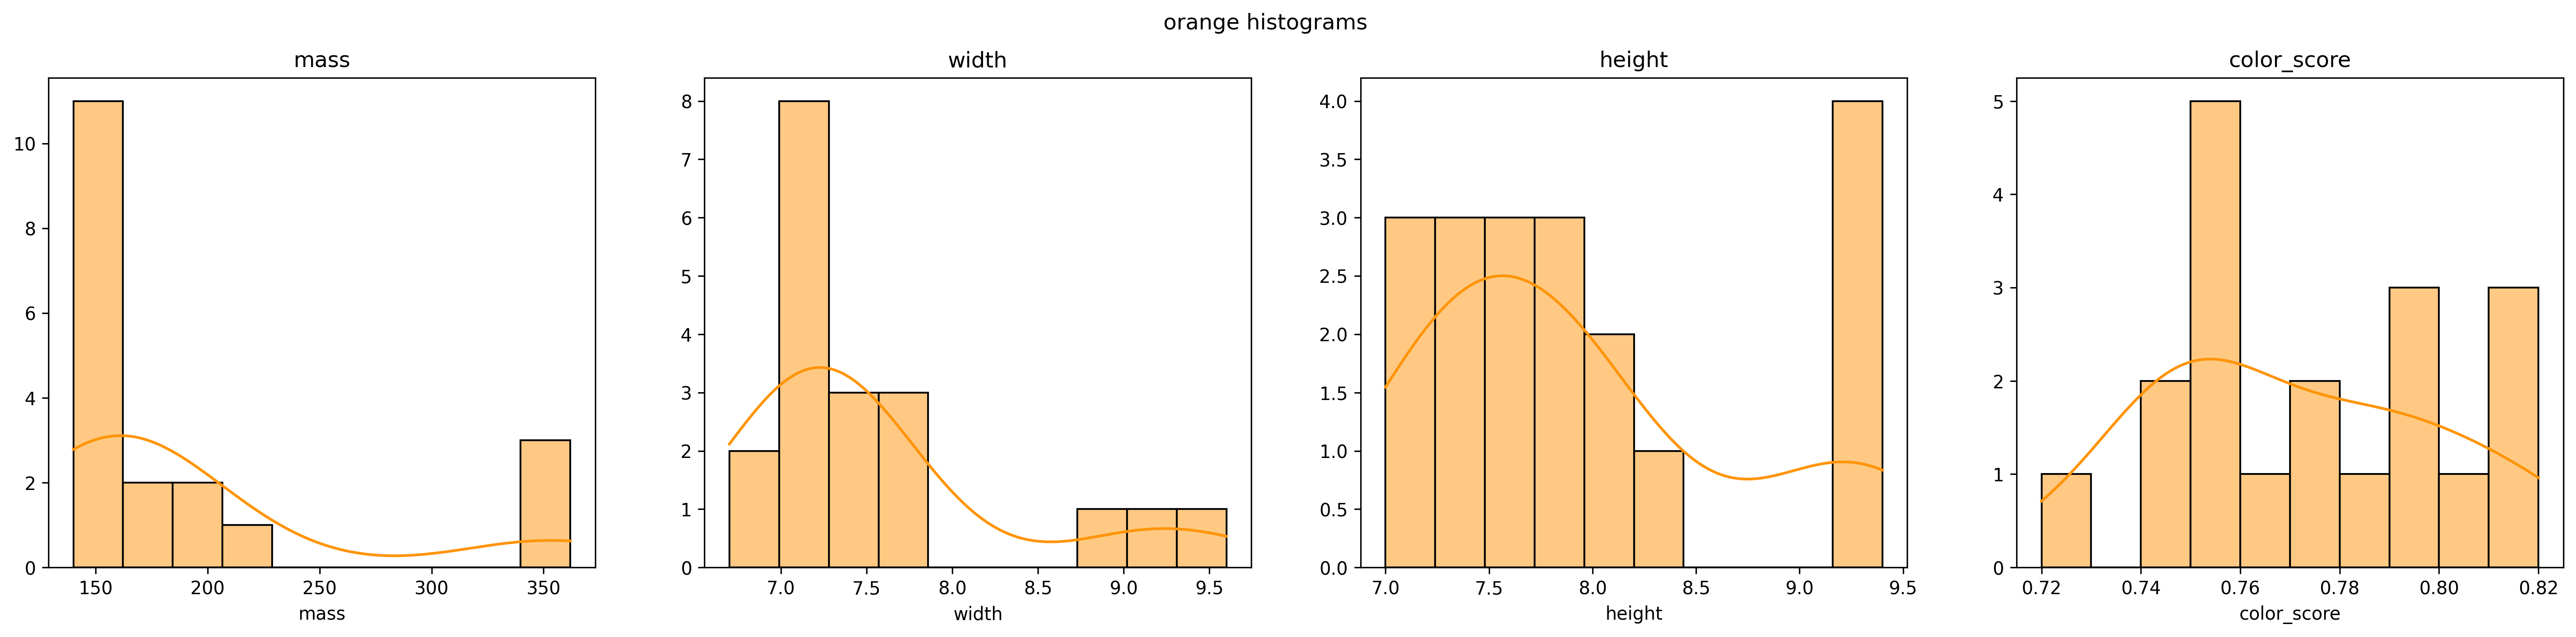

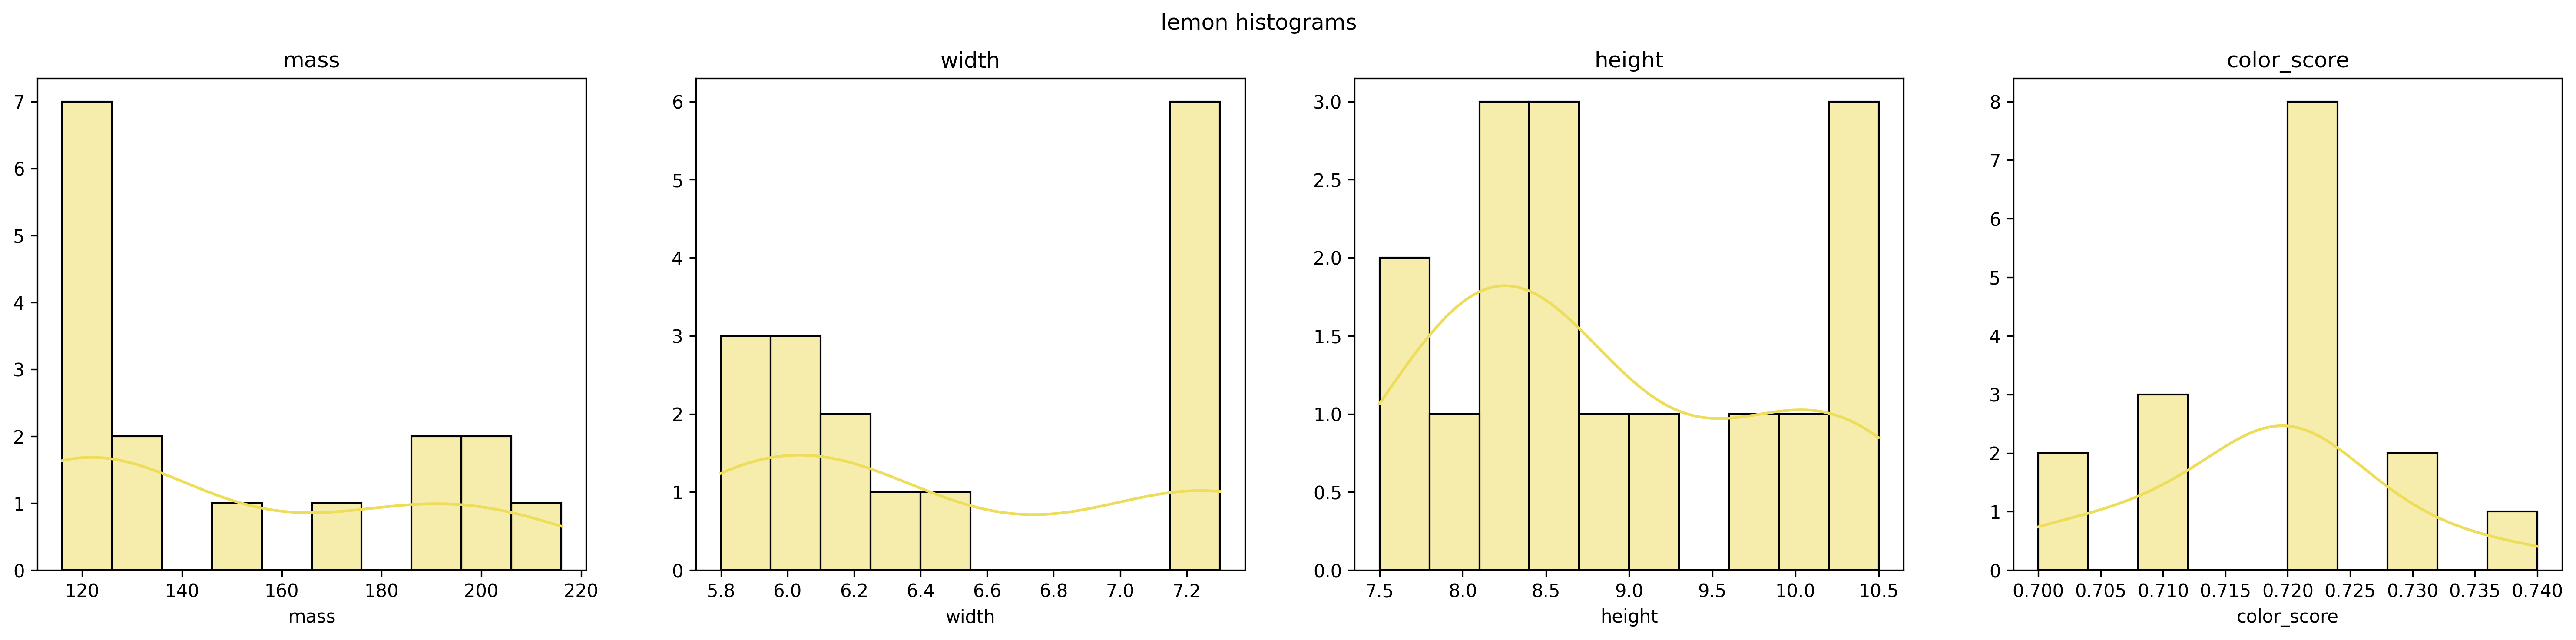

In [ ]:
for row, name in enumerate(fruit_names):
    fig, ax = plt.subplots(1, 4, figsize=(25, 5))
    sns.histplot(data=fruits[fruits['fruit_name'] == name], x='mass', ax=ax[0], color=colors[row], kde=True, bins=10)
    sns.histplot(data=fruits[fruits['fruit_name'] == name], x='width', ax=ax[1], color=colors[row], kde=True, bins=10)
    sns.histplot(data=fruits[fruits['fruit_name'] == name], x='height', ax=ax[2], color=colors[row], kde=True, bins=10)
    sns.histplot(data=fruits[fruits['fruit_name'] == name], x='color_score', ax=ax[3], color=colors[row], kde=True, bins=10)
    for a in ax:
        a.set_ylabel('')
        a.set_title(a.get_xlabel())
    fig.suptitle(f'{name} histograms')

## Scatterplot

A scatterplot was also made to see the relationship of variable in the data. All features seem to overlap in all scatterplots.

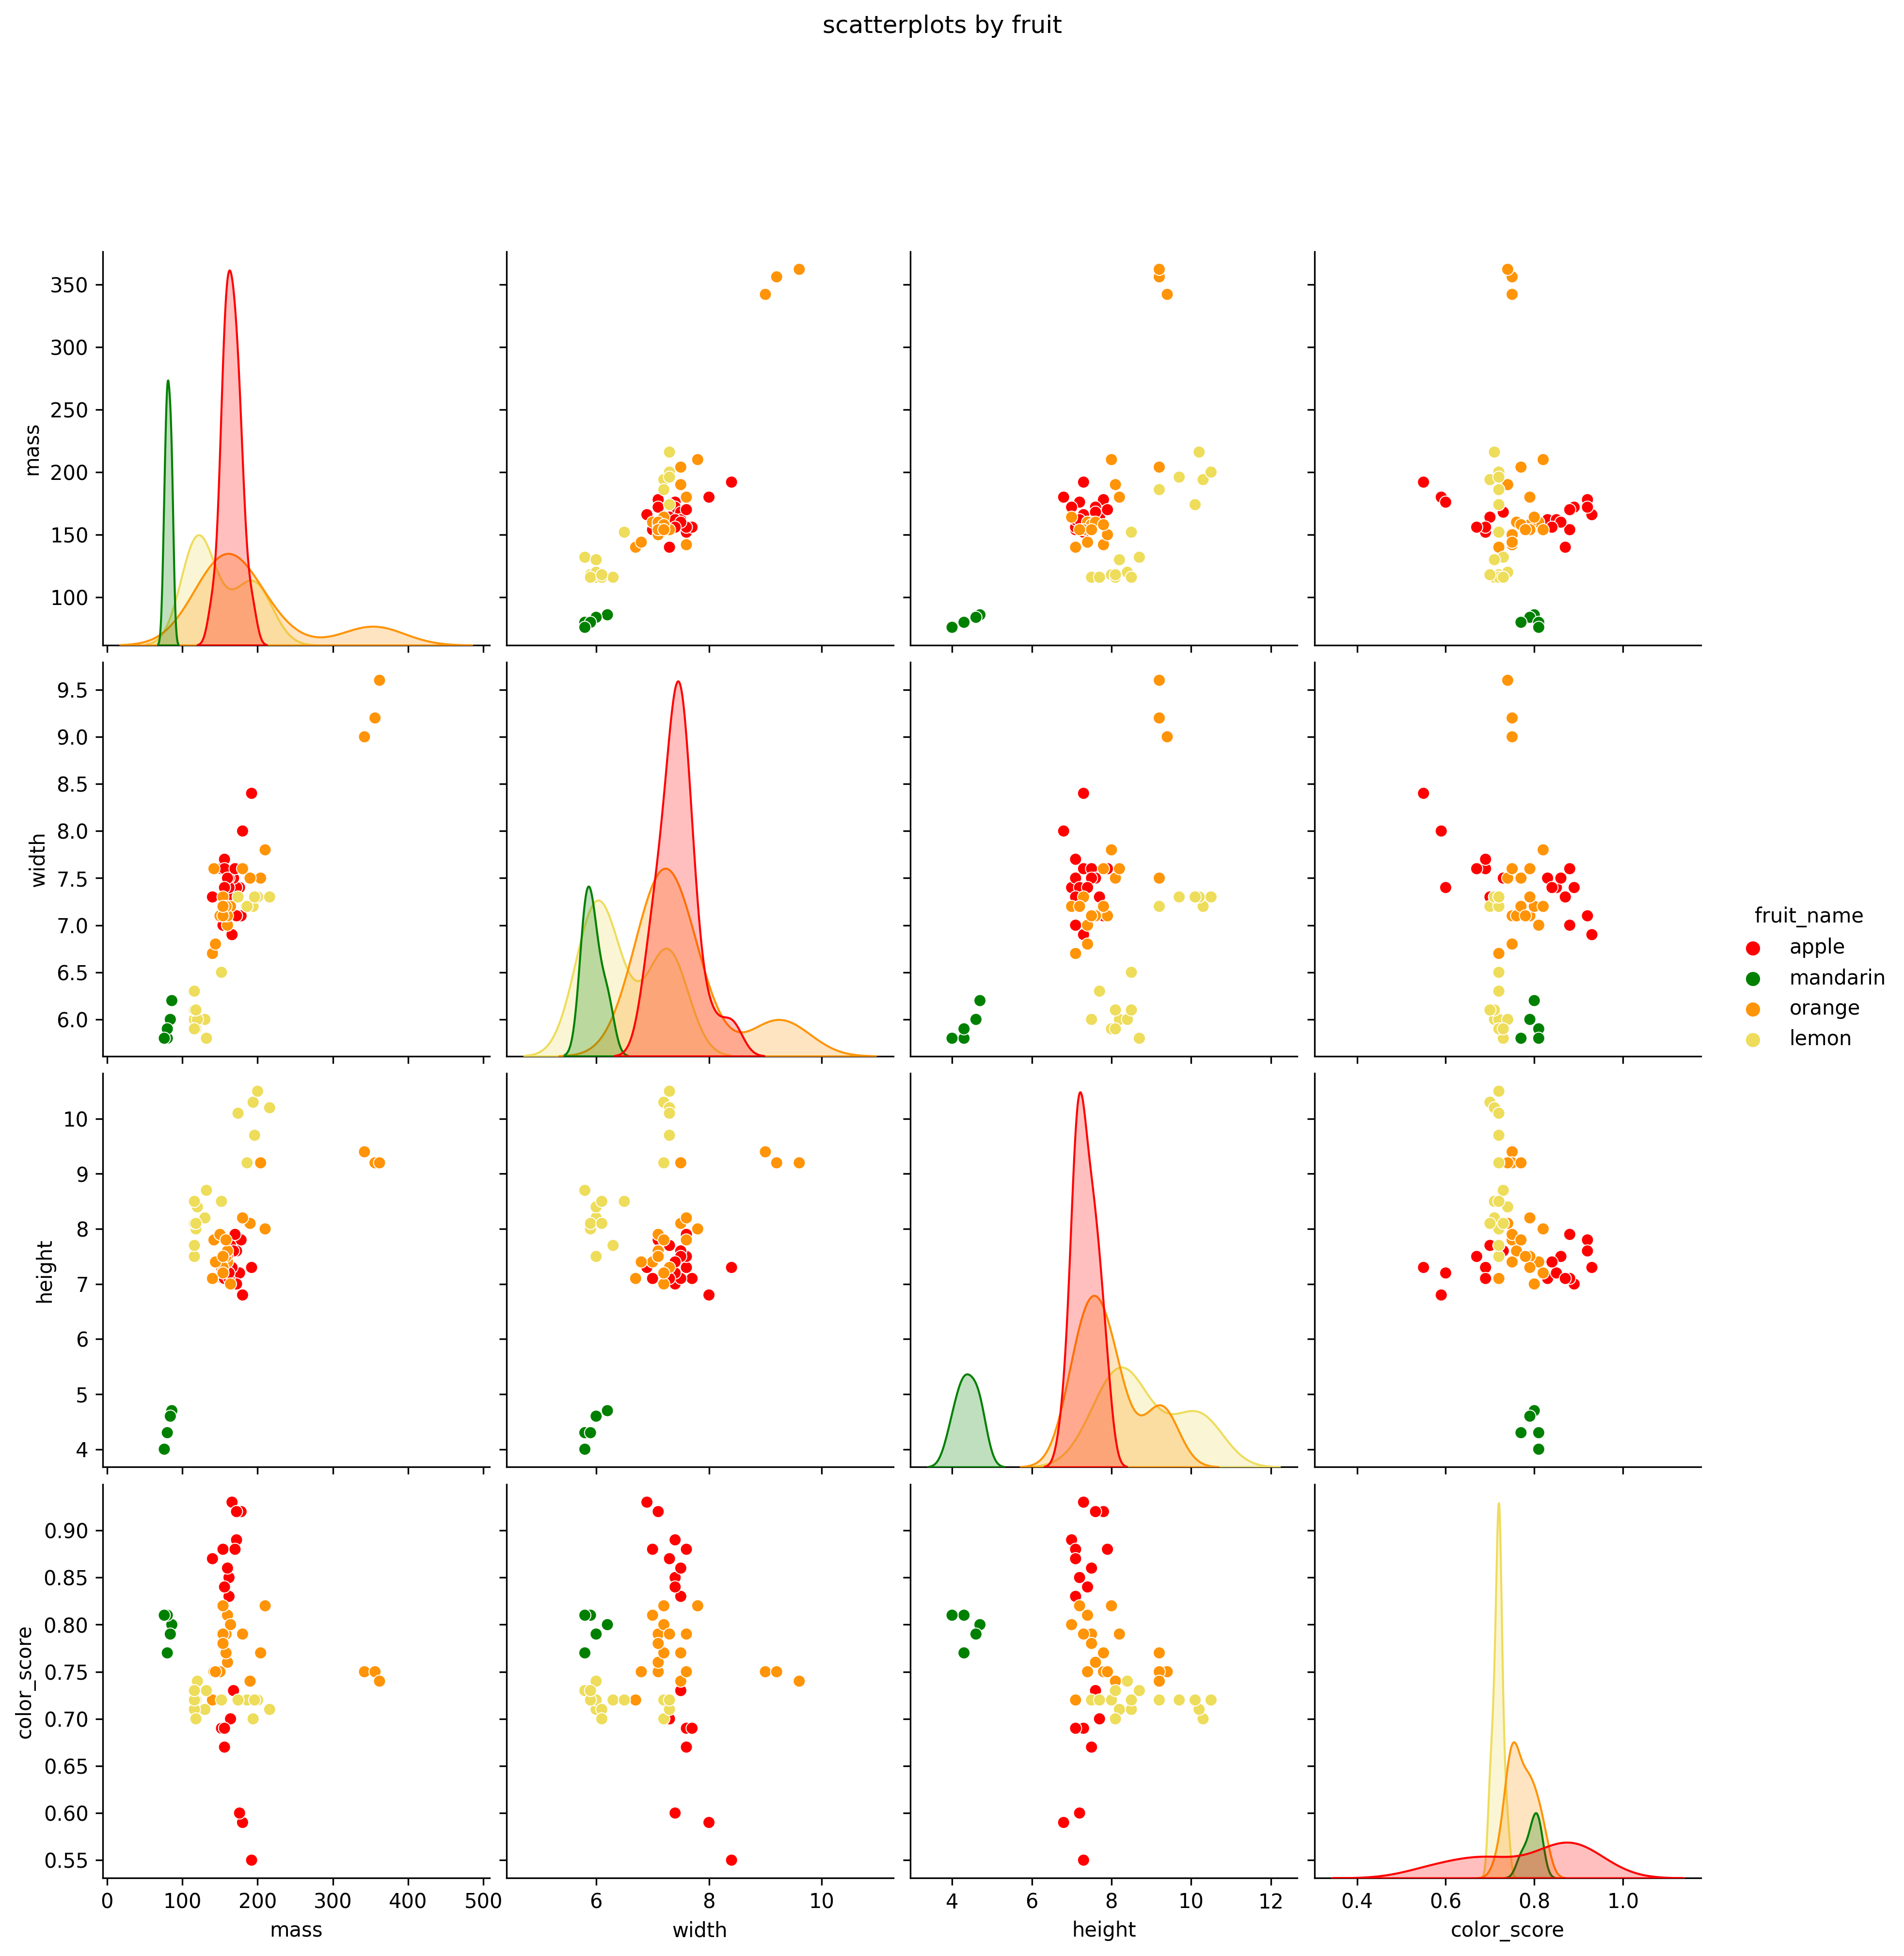

In [ ]:
sns.pairplot(fruits[numeric_cols + ['fruit_name']], hue='fruit_name', palette=colors, height=3, aspect=1)
plt.suptitle('scatterplots by fruit', y=1.12)
plt.show()

# Data Preprocessing

Before proceeding to machine learning methods, the data's features are pre-processed.

## 1/2/3: Look for and remove/impute missing values

There are no observed missing values in any of the features, therefore no removal or imputation was performed.

In [ ]:
fruits.isna().sum()

fruit_label      0
fruit_name       0
fruit_subtype    0
mass             0
width            0
height           0
color_score      0
dtype: int64

## 4: Handle categorical values

The dataset has two non-numerical features, the target feature `fruit_name` and another feature, `fruit_subtype`.

In [ ]:
fruits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fruit_label    59 non-null     int64  
 1   fruit_name     59 non-null     object 
 2   fruit_subtype  59 non-null     object 
 3   mass           59 non-null     int64  
 4   width          59 non-null     float64
 5   height         59 non-null     float64
 6   color_score    59 non-null     float64
dtypes: float64(3), int64(2), object(2)
memory usage: 3.4+ KB


`fruit_name` has already been label encoded through another feature, `fruit_label`. `fruit_name` may be dropped entirely, and `fruit_label` will serve as the target representing it.

| Fruit Name | Fruit Label |
| :--: | :--: |
| Apple | 1 |
| Mandarin | 2 |
| Orange | 3 |
| Lemons | 4 |

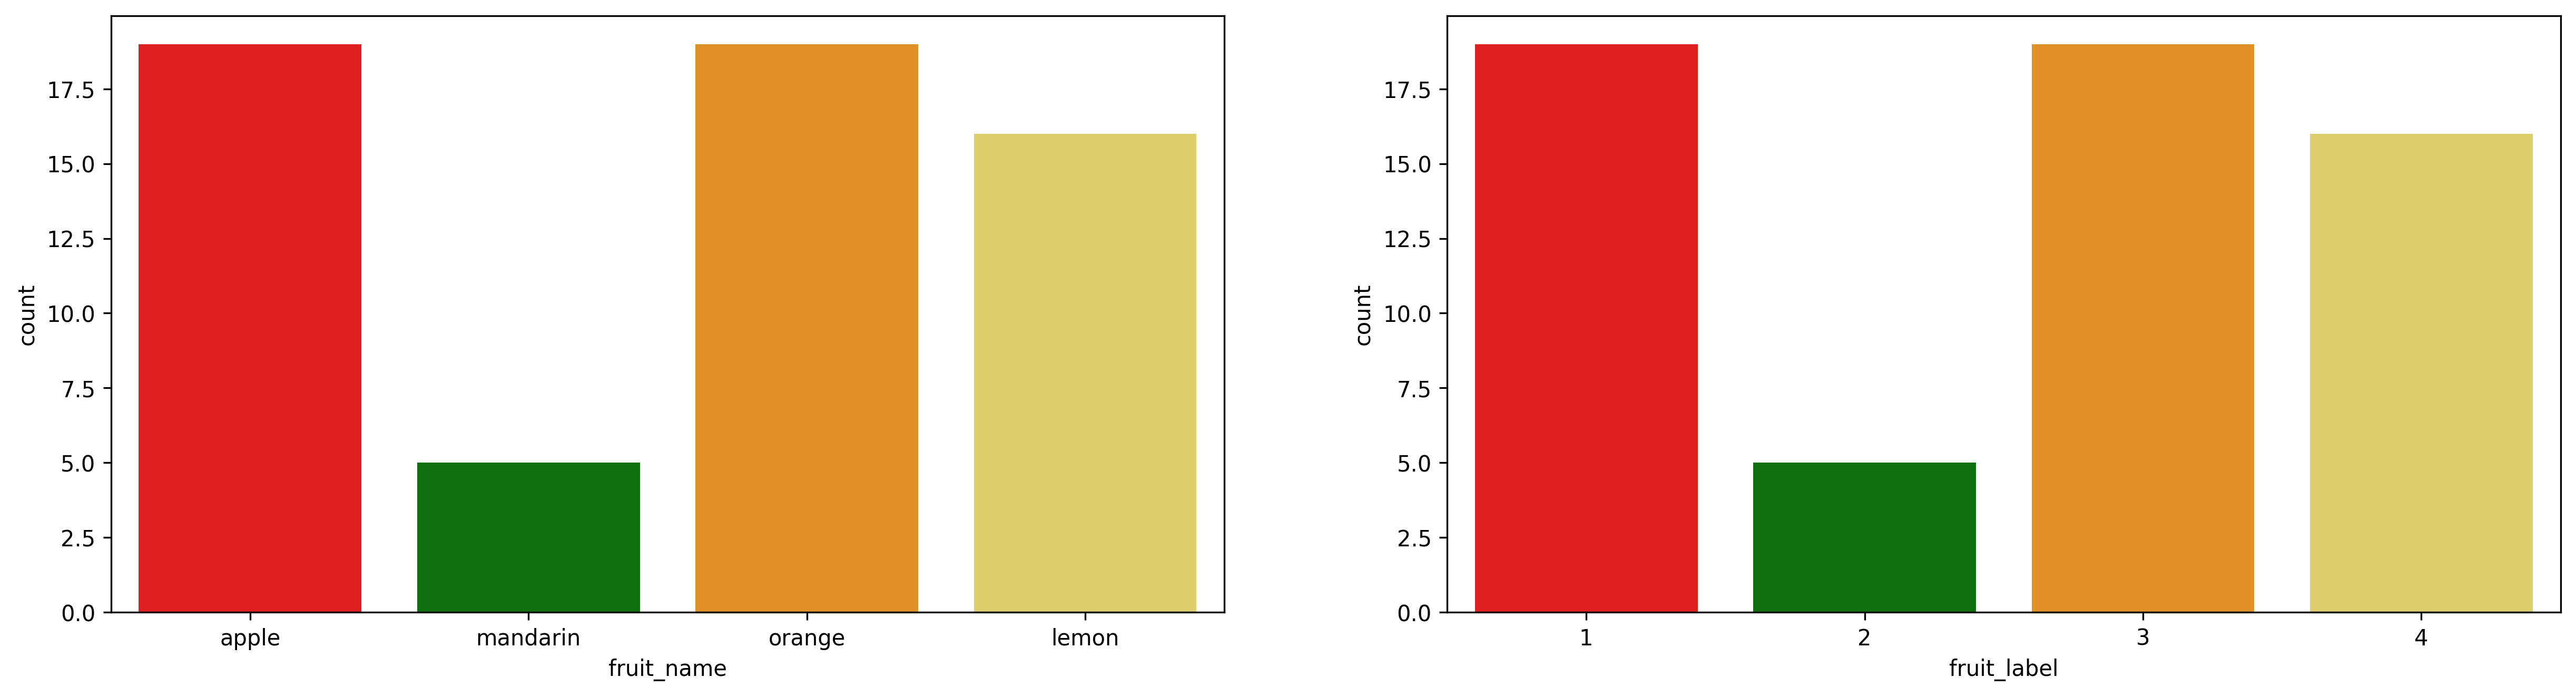

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.countplot(data=fruits, x='fruit_name', palette=colors, ax=ax[0])
sns.countplot(data=fruits, x='fruit_label', palette=colors, ax=ax[1])
plt.show()

The other categorical feature, `fruit_subtype` is a nominal feature that can be handled through one hot encoding. However, if the nature of the model is to predict the classification of the fruit, the `fruit_subtype` would most definitely be an unknown value too. (A fruit's subtype cannot be known without knowing what the fruit is to begin with).

When grouping `fruit_subtype` per `fruit_name`, we see that each subtype falls cleanly under a specific fruit, even `unknown`, only under `lemon`.

The group will do a run which includes a one hot encoded `fruit_subtype`, and another run which excludes this feature.

In [7]:
pd.DataFrame(fruits.groupby(['fruit_name', 'fruit_subtype']).size(), columns=['count'])

count
fruit_name fruit_subtype          
apple      braeburn              5
           cripps_pink           6
           golden_delicious      5
           granny_smith          3
lemon      spanish_belsan        6
           unknown              10
mandarin   mandarin              5
orange     selected_seconds      6
           spanish_jumbo         3
           turkey_navel         10

In [8]:
X = fruits.drop(['fruit_name', 'fruit_label'], axis=1) # Remove the target variable/s
y = fruits['fruit_label']

1 of the 9 one hot encoded columns is removed to avoid multicollinearity.

In [9]:
X = pd.get_dummies(X)
X.drop('fruit_subtype_unknown', axis=1, inplace=True) # Degrees of freedom
X_cols = X.columns
X.head()

,mass,width,height,color_score,fruit_subtype_braeburn,fruit_subtype_cripps_pink,fruit_subtype_golden_delicious,fruit_subtype_granny_smith,fruit_subtype_mandarin,fruit_subtype_selected_seconds,fruit_subtype_spanish_belsan,fruit_subtype_spanish_jumbo,fruit_subtype_turkey_navel
0,192,8.4,7.3,0.55,0,0,0,1,0,0,0,0,0
1,180,8.0,6.8,0.59,0,0,0,1,0,0,0,0,0
2,176,7.4,7.2,0.60,0,0,0,1,0,0,0,0,0
3,86,6.2,4.7,0.80,0,0,0,0,1,0,0,0,0
4,84,6.0,4.6,0.79,0,0,0,0,1,0,0,0,0


## 5: Apply scaler

A min-max scaler was applied to normalize the values of all features. As not all features are not normally-distributed based on the histograms, such as `width`, with 2 peaks, it would make less sense to apply a standard scaler.

In [10]:
scale = MinMaxScaler()
X = scale.fit_transform(X.astype(float))

In [11]:
X = pd.DataFrame(X, columns=X_cols)
X.head()

,mass,width,height,color_score,fruit_subtype_braeburn,fruit_subtype_cripps_pink,fruit_subtype_golden_delicious,fruit_subtype_granny_smith,fruit_subtype_mandarin,fruit_subtype_selected_seconds,fruit_subtype_spanish_belsan,fruit_subtype_spanish_jumbo,fruit_subtype_turkey_navel
0,0.405594,0.684211,0.507692,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.363636,0.578947,0.430769,0.105263,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.349650,0.421053,0.492308,0.131579,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.034965,0.105263,0.107692,0.657895,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.027972,0.052632,0.092308,0.631579,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Auto ML

Each method went through 30 trials for each parameter setting. For knn, n_neighbors tested were 1 up to the length of the dataset. For logistic regression and linear SVM, C's tested were 1, 1.5, 3, 5, 10, 15, 20, 100, 300, 1000, 5000.

Values of C less than 1 took considerable time to converge, and after converging, the best values of C would still be around 1-1.5 (with subtype), or 100-5000 (without subtype).

In [ ]:
trials = np.arange(1, 31)

def train_knn(X, y):
    all_train = []
    all_test = []
    for seed in trials:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        n_train = []
        n_test = []
        for n_neighbor in range(1, len(X_train)):
            model =  KNeighborsClassifier(n_neighbors=n_neighbor).fit(X_train, y_train)
            n_train.append(model.score(X_train, y_train))
            n_test.append(model.score(X_test, y_test))
        all_train.append(n_train)
        all_test.append(n_test)
    train_score = np.mean(all_train, axis=0)
    test_score = np.mean(all_test, axis=0)
    run_time = (time.time() - start_time)
    return ['kNN', np.amax(train_score), np.amax(test_score), f'N_Neighbor = {np.argmax(test_score)+1}', 'NA', run_time]

def train_logistic(X, y, reg):
    C = [1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000]
    all_train = []
    all_test = []
    all_coeffs=[]
    for seed in trials:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        c_train = []
        c_test = []
        for alpha_run in C:
            if reg == 'l1':
                lr = LogisticRegression(C=alpha_run, penalty=reg, solver='liblinear', max_iter=1000000).fit(X_train, y_train)
            if reg == 'l2':
                lr = LogisticRegression(C=alpha_run, penalty=reg, dual=False, max_iter=1000000).fit(X_train, y_train)
            c_train.append(lr.score(X_train, y_train))
            c_test.append(lr.score(X_test, y_test))
            all_coeffs.append(lr.coef_)
        all_train.append(c_train)
        all_test.append(c_test)
    
    mean_coeffs = np.mean(all_coeffs, axis=0).mean(axis=0)
    top_predictor = X.columns[np.argmax(np.abs(mean_coeffs))]
    train_score = np.mean(all_train, axis=0)
    test_score = np.mean(all_test, axis=0)
    run_time = (time.time() - start_time)
    return [f'Logistic ({reg})', np.amax(train_score), np.amax(test_score), f'C = {C[np.argmax(test_score)]}', top_predictor, run_time]

def train_svm(X, y, reg):
    C = [1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000]
    all_train = []
    all_test = []
    all_coeffs=[]
    for seed in trials:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        c_train = []
        c_test = []
        for alpha_run in C:
            if reg == 'l1':
                svc = LinearSVC(C=alpha_run, penalty=reg, loss='squared_hinge', dual=False, max_iter=1000000).fit(X_train, y_train)
            if reg == 'l2':
                svc = LinearSVC(C=alpha_run, penalty=reg, max_iter=1000000).fit(X_train, y_train)
            c_train.append(svc.score(X_train, y_train))
            c_test.append(svc.score(X_test, y_test))
            all_coeffs.append(svc.coef_)
        all_train.append(c_train)
        all_test.append(c_test)
    
    mean_coeffs = np.mean(all_coeffs, axis=0).mean(axis=0)
    top_predictor = X.columns[np.argmax(np.abs(mean_coeffs))]
    train_score = np.mean(all_train, axis=0)
    test_score = np.mean(all_test, axis=0)
    run_time = (time.time() - start_time)

    return [f'LinearSVM ({reg})', np.amax(train_score), np.amax(test_score), f'C = {C[np.argmax(test_score)]}', top_predictor, run_time]

# Results

## With fruit subtypes

As expected, when `fruit_subtype` remains, the model has perfect accuracy in both training and test data for all methods. A subtype will easily dictate what type of fruit is being classified, like a target feature being present in the training features.

To avoid this, we do another run without `fruit_subtype`.

In [ ]:
models = []
start_time = time.time()

models.append(train_knn(X, y))
models.append(train_logistic(X, y, 'l1'))
models.append(train_logistic(X, y, 'l2'))
models.append(train_svm(X, y, 'l1'))
models.append(train_svm(X, y, 'l2'))

df = pd.DataFrame(models, columns = ['Machine Learning Method',
                                     'Training Accuracy',
                                     'Test Accuracy',
                                     'Best Parameter',
                                     'Top Predictor Variable',
                                     'Run Time'])
display(df)

,Machine Learning Method,Training Accuracy,Test Accuracy,Best Parameter,Top Predictor Variable,Run Time
0,kNN,1.0,1.0,N_Neighbor = 1,NA,9.827663
1,Logistic (l1),1.0,1.0,C = 1.5,width,11.540073
2,Logistic (l2),1.0,1.0,C = 1,fruit_subtype_selected_seconds,16.097285
3,LinearSVM (l1),1.0,1.0,C = 1,width,18.955910
4,LinearSVM (l2),1.0,1.0,C = 1,height,20.967640


## No fruit subtypes

Without `fruit_subtype`, the test accuracy is no longer 100% accurate. The best model is found using kNN where k=1, with a test accuracy of about 94.89%. On average, the most prevalent top predictors across all parameter settings and all four classes were mass, width, and height.

In [ ]:
# Remove the target variable/s and subtypes
X = fruits.drop(['fruit_name', 'fruit_label', 'fruit_subtype'], axis=1)
y = fruits['fruit_label']
# Apply scaler
X_cols = X.columns
scale = MinMaxScaler()
X = scale.fit_transform(X.astype(float))
X = pd.DataFrame(X, columns=X_cols)

models = []
start_time = time.time()

models.append(train_knn(X, y))
models.append(train_logistic(X, y, 'l1'))
models.append(train_logistic(X, y, 'l2'))
models.append(train_svm(X, y, 'l1'))
models.append(train_svm(X, y, 'l2'))

df = pd.DataFrame(models, columns = ['Machine Learning Method',
                                     'Training Accuracy',
                                     'Test Accuracy',
                                     'Best Parameter',
                                     'Top Predictor Variable',
                                     'Run Time'])
display(df)

,Machine Learning Method,Training Accuracy,Test Accuracy,Best Parameter,Top Predictor Variable,Run Time
0,kNN,1.000000,0.948889,N_Neighbor = 1,NA,9.390206
1,Logistic (l1),0.824242,0.742222,C = 5000,width,11.245648
2,Logistic (l2),0.868939,0.813333,C = 5000,height,19.226354
3,LinearSVM (l1),0.812879,0.722222,C = 100,mass,21.220195
4,LinearSVM (l2),0.811364,0.717778,C = 1000,mass,62.058480


# References

* https://towardsdatascience.com/solving-a-simple-classification-problem-with-python-fruits-lovers-edition-d20ab6b071d2
* https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/fruit_data_with_colors.txt
* https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Solving%20A%20Simple%20Classification%20Problem%20with%20Python.ipynb